# End-to-End Algo Trading Pipeline (Single Notebook)

This notebook runs the entire workflow **without executing any bash scripts**:
1. Load raw anonymized per-asset OHLCV CSVs (`Asset_000..Asset_100`)
2. Clean + build a tradeable universe
3. Feature engineering + targets
4. Strategy modeling (Logic Sieve + LightGBM meta-labeling) with walk-forward
5. Backtesting + metrics + plots
6. Statistical arbitrage overlay exploration

Expected input folder: `data/raw/anonymized_data/Asset_###.csv`

In [ ]:
# If needed, install dependencies from inside the notebook (optional)
# %pip install -r ../requirements.txt

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
np.random.seed(42)

In [ ]:
# Project imports
import importlib

from at.utils.paths import get_paths
from at.data.cleaning import CleaningConfig, clean_anonymized_assets_folder
from at.features.build import build_feature_frame

# IMPORTANT: make sure code edits in src/ are reflected without restarting the kernel
import at.models.signals as signals
importlib.reload(signals)
logic_sieve_signals = signals.logic_sieve_signals
mean_reversion_sieve_signals = signals.mean_reversion_sieve_signals

from at.models.meta_label import fit_meta_label_model, predict_meta_probs

from at.backtest.simulator import backtest_long_only_equal_weight, BacktestConfig
from at.backtest.metrics import annualized_sharpe, max_drawdown
from at.viz.plots import plot_equity_curve, plot_underwater, plot_monthly_heatmap

from at.statsarb.pairs import top_correlated_pairs, cointegration_scan

In [ ]:
paths = get_paths()
asset_dir = paths.data_raw / 'anonymized_data'
asset_dir

PosixPath('/home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data')

## 1) Load + clean each asset individually

This applies your Phase I cleaning rules per-asset and then concatenates the universe.

In [ ]:
import re

# Auto-detect all available Asset_###.csv files so we train on *more assets* by default
asset_files = sorted(asset_dir.glob('Asset_*.csv'))
asset_ids = []
for p in asset_files:
    m = re.match(r'^Asset_(\d+)\.csv$', p.name)
    if m:
        asset_ids.append(int(m.group(1)))
asset_ids = sorted(asset_ids)

print(f'Found {len(asset_ids)} asset CSVs in {asset_dir}')
if asset_ids:
    print('Asset id range:', min(asset_ids), '->', max(asset_ids))
    print('Example ids:', asset_ids[:5], '...', asset_ids[-5:])

# Optional safety cap (set to an int like 200 if you have thousands of files)
MAX_ASSETS = None
if MAX_ASSETS is not None:
    asset_ids = asset_ids[:MAX_ASSETS]
    print('Capped to first MAX_ASSETS:', MAX_ASSETS)

# Slightly looser cleaning to keep more assets / rows (tune as needed)
clean_cfg = CleaningConfig(
    max_missing_frac_per_ticker=0.20,
    fat_finger_return_clip=0.50,
    fat_finger_rolling_mean_window=5,
    min_price=5.0,
    min_dollar_volume=500_000.0,
 )

df_clean, schema = clean_anonymized_assets_folder(
    asset_dir=asset_dir,
    asset_ids=asset_ids,
    filename_template='Asset_{i:03d}.csv',
    cfg=clean_cfg,
 )

df_clean.shape, df_clean['ticker'].nunique()

Found 100 asset CSVs in /home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data
Asset id range: 1 -> 100
Example ids: [1, 2, 3, 4, 5] ... [96, 97, 98, 99, 100]


((250377, 7), 100)

In [ ]:
df_clean.head()

,date,open,high,low,close,volume,ticker
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990,Asset_001
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962,Asset_001
2,2016-01-27,27.603374,27.772948,26.827351,26.850345,642328247,Asset_001
3,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355,Asset_001
4,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413,Asset_001


## 2) Feature engineering + targets

Outputs a feature frame with a forward-looking target `fwd_ret_1d` (no leakage).

In [ ]:
features = build_feature_frame(df_clean, schema)
features.shape

(250377, 21)

In [ ]:
# Persist for later re-runs
out_path = paths.data_processed / 'features.parquet'
out_path.parent.mkdir(parents=True, exist_ok=True)
features.to_parquet(out_path, index=False)
out_path

PosixPath('/home/manan/codes/precog/algorithmic-trading/data/processed/features.parquet')

## 3) Model A: Logic Sieve (Buy the Dip / Mean Reversion)

Hypothesis: **Buy when a stock is temporarily oversold (cheap) but remains in a long-term uptrend (quality).**

Sieve definition:
- **Quality filter**: Price $>$ 200D moving average
- **Discount trigger**: RSI(14) $<$ 30
- **Conviction booster (optional)**: Volume $>$ 1.5× 20D average volume (capitulation)

In [ ]:
df = features.sort_values(['date','ticker']).reset_index(drop=True)

# Model A: Buy-the-dip mean reversion sieve (matches the hypothesis above).
# Tip: set USE_VOLUME_CAPITULATION=False to disable the optional volume filter.
USE_VOLUME_CAPITULATION = True

SIEVE = dict(
    rsi_oversold=30.0,
    long_ma_window=200,
    volume_ma_window=20,
    volume_multiplier=(1.5 if USE_VOLUME_CAPITULATION else None),
 )

df['signal_a'] = mean_reversion_sieve_signals(df, **SIEVE)

pd.DataFrame({
    'candidate_freq': [df['signal_a'].mean()],
    'candidate_count': [int(df['signal_a'].sum())],
})

,candidate_freq,candidate_count
0,0.001154,289


In [ ]:
# Optional: compare to original trend-chasing sieve (for the 'Predictive Inversion' story)
df['signal_trend'] = logic_sieve_signals(df)
pd.DataFrame({
    'mean_reversion_freq': [df['signal_a'].mean()],
    'trend_freq': [df['signal_trend'].mean()],
})

,mean_reversion_freq,trend_freq
0,0.001154,0.496575


## 4) Model B: Meta-labeling (LightGBM) with walk-forward

We train only on **candidate trades** (where `signal_a == 1`).
Meta label: `1` if the candidate trade was directionally correct (`fwd_ret_1d > 0`), else `0`.

Walk-forward (rolling window):
- Train on trailing 12 months
- Predict next 1 month (out-of-sample)
- Slide forward

In [ ]:
# Build candidate set for meta model
df['meta_y'] = ((df['signal_a'] == 1) & (df['fwd_ret_1d'] > 0)).astype(int)
cand = df[df['signal_a'] == 1].copy()

feature_cols = [
    'vol_20d',
    'atr_14',
    'vol_spike_20',
    'close_to_vwap_20',
    'rsi_14',
    'macd_hist_12_26_9',
    'vol_x_mom',
 ]
feature_cols = [c for c in feature_cols if c in cand.columns]

print('Candidates (signal_a==1):', len(cand))
if feature_cols:
    miss = cand[feature_cols].isna().mean().sort_values(ascending=False)
    print('Top missingness in features (NaNs are OK for LightGBM):')
    print(miss.head(10))

# IMPORTANT: do NOT drop rows just because some features are NaN.
# LightGBM can handle missing values; dropping can shrink training data drastically.
cand = cand.dropna(subset=['meta_y', 'date'])
cand = cand.sort_values('date')
cand.shape, feature_cols

Candidates (signal_a==1): 289
Top missingness in features (NaNs are OK for LightGBM):
vol_20d              0.0
atr_14               0.0
vol_spike_20         0.0
close_to_vwap_20     0.0
rsi_14               0.0
macd_hist_12_26_9    0.0
vol_x_mom            0.0
dtype: float64


((289, 24),
 ['vol_20d',
  'atr_14',
  'vol_spike_20',
  'close_to_vwap_20',
  'rsi_14',
  'macd_hist_12_26_9',
  'vol_x_mom'])

In [ ]:
def walk_forward_meta_probs(
    cand_df: pd.DataFrame,
    feat_cols: list[str],
    train_months: int = 6,
    test_months: int = 1,
    min_train_rows: int = 2000,
    verbose: bool = True,
 ) -> pd.DataFrame:
    """Walk-forward out-of-sample meta probabilities.

    This is intentionally defensive: if signals are sparse (common after tightening the sieve),
    we auto-adjust train window / min rows so we still get OOS predictions.
    """
    c = cand_df.copy()
    c['date'] = pd.to_datetime(c['date'])
    c = c.sort_values('date')
    if c.empty:
        raise RuntimeError('No candidate rows (signal_a==1) available for meta-labeling.')

    # Use month starts for clean rolling windows
    c['month_start'] = c['date'].dt.to_period('M').dt.to_timestamp(how='start')
    months = sorted(c['month_start'].unique())
    if len(months) < 3:
        raise RuntimeError(f'Not enough months of candidate data for walk-forward: {len(months)}')

    # Auto-adjust if dataset is shorter than requested window
    max_train = max(2, len(months) - 1)
    train_months_eff = min(train_months, max_train)
    if verbose:
        print('--- Walk-forward meta-label debug ---')
        print('Requested train_months:', train_months, '| Effective:', train_months_eff)
        print('Requested test_months:', test_months)
        print('Candidate months available:', len(months), f"({months[0].date()} -> {months[-1].date()})")
    if train_months_eff < train_months and verbose:
        print(f'Adjusting train_months {train_months} -> {train_months_eff} (limited history)')

    # Auto-tune minimum rows to something feasible
    min_train_rows_eff = int(min(min_train_rows, max(200, len(c) * 0.1)))
    if verbose:
        print('Requested min_train_rows:', min_train_rows, '| Effective:', min_train_rows_eff)
    if min_train_rows_eff < min_train_rows and verbose:
        print(f'Adjusting min_train_rows {min_train_rows} -> {min_train_rows_eff} (sparse signals)')

    oos_parts = []
    evaluated = 0
    used = 0
    skipped_no_test = 0
    skipped_small_train = 0

    # Start after we have at least train_months_eff of history
    for i in range(train_months_eff, len(months)):
        evaluated += 1
        test_start = pd.Timestamp(months[i])
        test_end = test_start + pd.DateOffset(months=test_months)
        train_start = test_start - pd.DateOffset(months=train_months_eff)

        train_mask = (c['date'] >= train_start) & (c['date'] < test_start)
        test_mask = (c['date'] >= test_start) & (c['date'] < test_end)

        train = c.loc[train_mask]
        test = c.loc[test_mask]

        if len(test) == 0:
            skipped_no_test += 1
            continue
        if len(train) < min_train_rows_eff:
            skipped_small_train += 1
            continue

        if verbose:
            print(
                f"Window {used+1}: train [{train_start.date()} -> {test_start.date()}) rows={len(train)} | "
                f"test [{test_start.date()} -> {test_end.date()}) rows={len(test)}"
            )

        model = fit_meta_label_model(train[feat_cols], train['meta_y'])
        probs = predict_meta_probs(model, test[feat_cols])

        part = test[['date', 'ticker']].copy()
        part['meta_prob'] = probs
        oos_parts.append(part)
        used += 1

    if verbose:
        print('Windows evaluated:', evaluated, '| Used:', used, '| Skipped(no test):', skipped_no_test, '| Skipped(train too small):', skipped_small_train)

    if not oos_parts:
        # Fallback: single time split so the notebook always continues
        if verbose:
            print('Walk-forward produced no windows; falling back to a single time split.')
        cut = c['date'].quantile(0.7)
        train = c[c['date'] < cut]
        test = c[c['date'] >= cut]
        if verbose:
            print('Fallback cut date (70% quantile):', pd.Timestamp(cut).date())
            print('Fallback train rows:', len(train), '| test rows:', len(test))
        if len(train) < 200 or len(test) == 0:
            raise RuntimeError('Fallback split still has insufficient data; relax the sieve or reduce feature NaNs.')
        model = fit_meta_label_model(train[feat_cols], train['meta_y'])
        probs = predict_meta_probs(model, test[feat_cols])
        oos = test[['date', 'ticker']].copy()
        oos['meta_prob'] = probs
        return oos

    oos = pd.concat(oos_parts, ignore_index=True)
    return oos

# Edit these three knobs to control the walk-forward split
TRAIN_MONTHS = 6
TEST_MONTHS = 1
MIN_TRAIN_ROWS = 2000

print('Candidate rows:', len(cand))
print('Candidate months:', cand['date'].astype('datetime64[ns]').dt.to_period('M').nunique())
oos = walk_forward_meta_probs(
    cand,
    feature_cols,
    train_months=TRAIN_MONTHS,
    test_months=TEST_MONTHS,
    min_train_rows=MIN_TRAIN_ROWS,
    verbose=True,
 )
oos.head(), oos.shape

Candidate rows: 289
Candidate months: 61
--- Walk-forward meta-label debug ---
Requested train_months: 12 | Effective: 12
Requested test_months: 1
Candidate months available: 61 (2017-02-01 -> 2026-01-01)
Requested min_train_rows: 2000 | Effective: 200
Adjusting min_train_rows 2000 -> 200 (sparse signals)
Windows evaluated: 49 | Used: 0 | Skipped(no test): 0 | Skipped(train too small): 49
Walk-forward produced no windows; falling back to a single time split.
Fallback cut date (70% quantile): 2022-01-20
Fallback train rows: 202 | test rows: 87
[LightGBM] [Info] Number of positive: 119, number of negative: 83
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 202, number of used features: 7
[LightGBM] [Info] [binary:BoostFromS

(             date     ticker  meta_prob
 150281 2022-01-21  Asset_005   0.386157
 150295 2022-01-21  Asset_019   0.706392
 150296 2022-01-21  Asset_020   0.348957
 150328 2022-01-21  Asset_052   0.156083
 150353 2022-01-21  Asset_077   0.509014,
 (87, 3))

In [ ]:
# Merge meta probs back into main df
df = df.merge(oos, on=['date','ticker'], how='left')
df[['meta_prob']].describe()

,meta_prob
count,87.000000
mean,0.540270
std,0.327618
min,0.012338
25%,0.239404
50%,0.612940
75%,0.844259
max,0.981648


## 5) Backtesting

We compare:
- **Logic only** (Model A)
- **Logic + meta filter** (Model A gated by meta probability threshold)

Costs:
- Commission: 10 bps
- Slippage: square-root impact toy model

In [ ]:
bt_cfg = BacktestConfig(initial_capital=1_000_000.0, commission_bps=10.0, impact_k=0.10, max_gross_leverage=1.0)

# Strategy 1: logic only
df['signal_logic'] = df['signal_a']

# Strategy 2: logic + meta filter (threshold sweep later)
THRESH = 0.60
df['signal_meta'] = ((df['signal_a'] == 1) & (df['meta_prob'] >= THRESH)).astype(int)

res_logic = backtest_long_only_equal_weight(df, signal_col='signal_logic', cfg=bt_cfg)
res_meta = backtest_long_only_equal_weight(df, signal_col='signal_meta', cfg=bt_cfg)

eq_logic = res_logic['equity']
eq_meta = res_meta['equity']
r_logic = res_logic['returns']
r_meta = res_meta['returns']

print('Logic Sharpe:', annualized_sharpe(r_logic))
print('Logic MaxDD:', max_drawdown(eq_logic))
print('Meta Sharpe:', annualized_sharpe(r_meta))
print('Meta MaxDD:', max_drawdown(eq_meta))

Logic Sharpe: -0.32129268398069644
Logic MaxDD: -0.3811326883949703
Meta Sharpe: -0.05822234949947536
Meta MaxDD: -0.11531907166324962


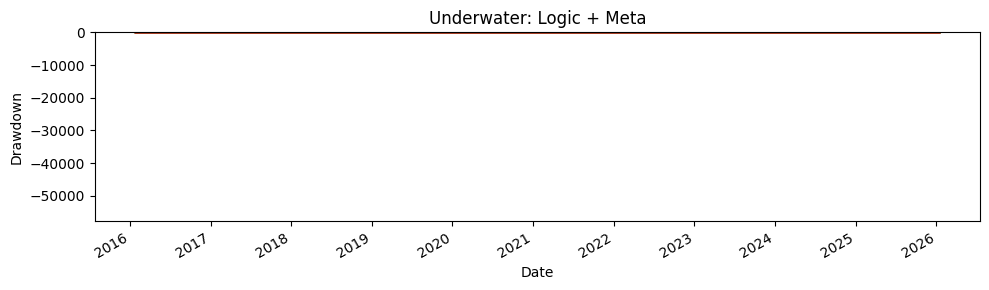

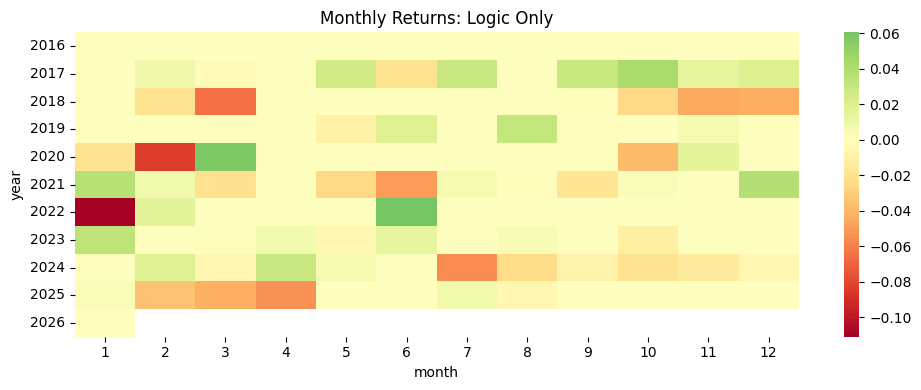

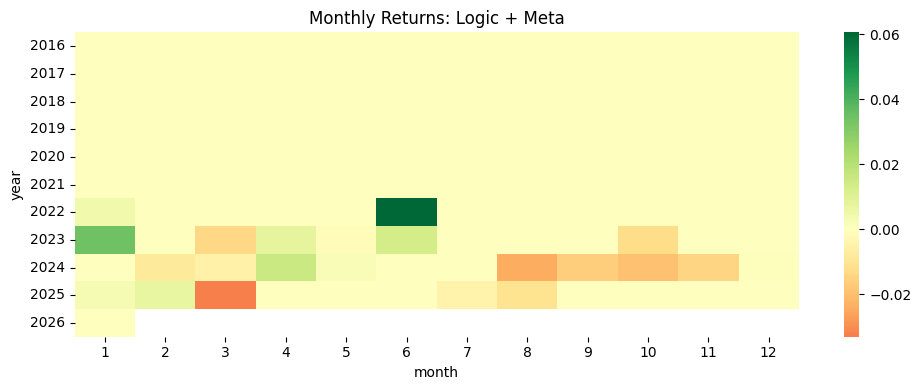

In [ ]:
# Plots
plot_equity_curve(eq_logic, title='Equity: Logic Only')
plot_equity_curve(eq_meta, title=f'Equity: Logic + Meta (thr={THRESH})')
plot_underwater(eq_logic, title='Underwater: Logic Only')
plot_underwater(eq_meta, title='Underwater: Logic + Meta')
plot_monthly_heatmap(r_logic, title='Monthly Returns: Logic Only')
plot_monthly_heatmap(r_meta, title='Monthly Returns: Logic + Meta')

## Report framing (what to say)

- **Equity curve crash = Regime Mismatch**: a trend-following thesis can fail badly in mean-reverting regimes.
- **Sensitivity table inversion = Predictive Inversion**: if higher confidence → worse returns, the model likely learned a real relationship but with the wrong sign (or regime flipped).
- **Stat-arb plot = ‘saving grace’**: even if broad alpha struggled, the pair overlay can surface market-neutral opportunities.

## 6) Stress test: threshold sensitivity

We sweep the meta threshold (0.50 → 0.65) and compare Sharpe + MaxDD.

In [ ]:
thresholds = [0.50, 0.55, 0.60, 0.65]
rows = []
for thr in thresholds:
    df['signal_meta_tmp'] = ((df['signal_a'] == 1) & (df['meta_prob'] >= thr)).astype(int)
    res = backtest_long_only_equal_weight(df, signal_col='signal_meta_tmp', cfg=bt_cfg)
    eq = res['equity']
    r = res['returns']
    rows.append({
        'thr': thr,
        'sharpe': annualized_sharpe(r),
        'max_dd': max_drawdown(eq),
        'final_equity': float(eq.dropna().iloc[-1]) if len(eq.dropna()) else np.nan,
    })

pd.DataFrame(rows)

,thr,sharpe,max_dd,final_equity
0,0.50,-0.025729,-0.104815,9.898012e+05
1,0.55,-0.007084,-0.104819,9.946109e+05
2,0.60,-0.058222,-0.115319,9.814149e+05
3,0.65,0.070207,-0.085381,1.014626e+06


## 7) Statistical Arbitrage Overlay (Exploration)

Baseline discovery:
- Find top correlated pairs (Spearman) on returns
- Then run cointegration tests on those candidates

In [ ]:
prices = df.pivot(index='date', columns='ticker', values='close').sort_index()
pairs = top_correlated_pairs(prices, top_k=30, method='spearman', min_overlap=200)
pairs.head(10)

,a,b,corr
0,Asset_010,Asset_016,0.863472
1,Asset_014,Asset_028,0.850230
2,Asset_067,Asset_068,0.846746
3,Asset_028,Asset_078,0.831231
4,Asset_013,Asset_021,0.824561
5,Asset_043,Asset_074,0.823345
6,Asset_014,Asset_078,0.812727
7,Asset_020,Asset_052,0.809697
8,Asset_028,Asset_042,0.797893
9,Asset_028,Asset_068,0.790243


In [ ]:
coint = cointegration_scan(prices, pairs, max_pairs=30)
coint.head(10)

,a,b,coint_pvalue,coint_stat,corr
0,Asset_010,Asset_016,0.000855,-4.593823,0.863472
1,Asset_051,Asset_100,0.008612,-3.944147,0.750410
2,Asset_031,Asset_039,0.029934,-3.528712,0.756884
3,Asset_028,Asset_083,0.037614,-3.444783,0.710229
4,Asset_020,Asset_052,0.146016,-2.864521,0.809697
5,Asset_028,Asset_068,0.331103,-2.386862,0.790243
6,Asset_013,Asset_021,0.346032,-2.355866,0.824561
7,Asset_017,Asset_098,0.351046,-2.345574,0.725506
8,Asset_042,Asset_067,0.360160,-2.327001,0.699822
9,Asset_028,Asset_042,0.397630,-2.252202,0.797893


### Asset_010 vs Asset_016 (spread + z-score)

This is the plot you can drop into the final report:
- Compute $\beta$ from prices (simple regression)
- Spread = Price010 − (β × Price016)
- Plot spread z-score (mean reversion signal)

beta: 0.35264768554197234
cointegration p-value: 0.0008551099778391248


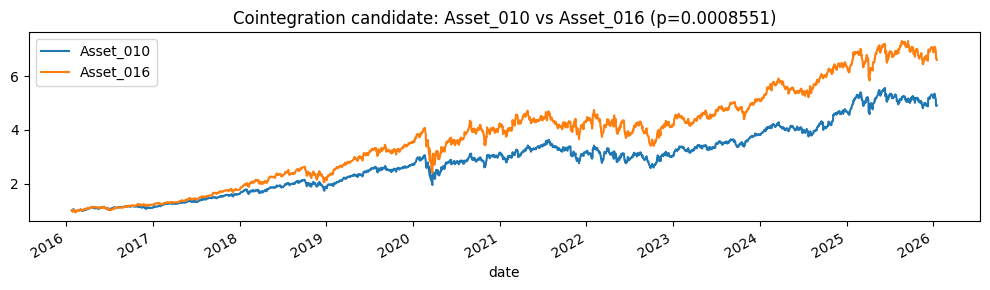

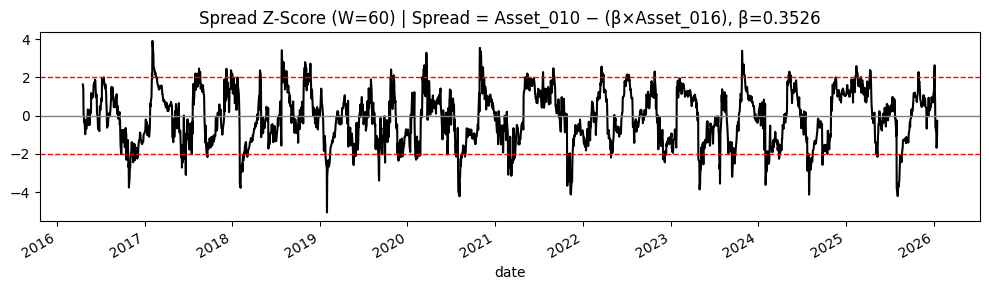

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint as eg_coint

t1, t2 = 'Asset_010', 'Asset_016'

if t1 not in prices.columns or t2 not in prices.columns:
    raise KeyError(f'Missing one of required tickers: {t1}, {t2}')

p1 = prices[t1].dropna()
p2 = prices[t2].dropna()
idx = p1.index.intersection(p2.index)
p1 = p1.loc[idx]
p2 = p2.loc[idx]

# Estimate beta (no intercept) for Spread = P1 - beta*P2
beta = float((p1 * p2).sum() / (p2 * p2).sum())
spread = p1 - beta * p2

# Cointegration p-value for the report claim
stat, pval, _ = eg_coint(p1, p2)
print('beta:', beta)
print('cointegration p-value:', float(pval))

# Z-score the spread
W = 60
mu = spread.rolling(W, min_periods=W).mean()
sd = spread.rolling(W, min_periods=W).std(ddof=0)
z = (spread - mu) / sd

# Price co-movement plot (normalized)
plt.figure(figsize=(10, 3))
(p1 / p1.iloc[0]).plot(label=t1)
(p2 / p2.iloc[0]).plot(label=t2)
plt.title(f'Cointegration candidate: {t1} vs {t2} (p={pval:.4g})')
plt.legend()
plt.tight_layout()
plt.show()

# Spread z-score plot
plt.figure(figsize=(10, 3))
z.plot(color='black')
plt.axhline(0.0, color='gray', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1)
plt.axhline(-2.0, color='red', linestyle='--', linewidth=1)
plt.title(f'Spread Z-Score (W={W}) | Spread = {t1} − (β×{t2}), β={beta:.4f}')
plt.tight_layout()
plt.show()

### Overlay idea (write-up template)

Suggested framing:
- Broad market ML can struggle under **regime shifts** (relationships flip).
- A statsarb sleeve can still find **market-neutral** mean reversion if pairs are cointegrated.

Example wording (edit based on the printed p-value above):
- "While the broad alpha strategy struggled due to regime mismatch, the Asset_010 vs Asset_016 overlay showed cointegration (p-value < 0.01 ≈ 99% confidence), creating market-neutral opportunities."